# Titanic: Predicting Survival

This notebook uses data from Kaggle competition "Titanic: Machine Learning from Disaster". Firstly, I engineer features to get maximum from the limited data available, and fill missing values of Age variable using linear regression. Then I compare performance of multiple classifiers, such as: logistic regression, SVM, k - nearest neighbours, Naive Bayes, Decision Tree Classifier. I also use ensemble methods such as random forest, bagging, boosting and voting classifier. I use grid search and cross validation to tune up the parameters of classifiers.

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import re

from pandas import DataFrame
from time import time
from operator import itemgetter
from scipy.stats import randint as sp_randint
from sklearn.datasets import load_digits

from sklearn import preprocessing

# Machine learning
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import RidgeClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score

from sklearn.grid_search import GridSearchCV


import os
os.chdir('C:\\Users\\Daria\\kaggle\\Titanic') 
os.getcwd() 

'C:\\Users\\Daria\\kaggle\\Titanic'

## Load data

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# preview the data
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S


In [3]:
# get concise summary of the data
test.info()
print("----------------------------")
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 39.2+ KB
----------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare 

# Feature Engineering

Let's have a closer look at every feature one by one.

## Embarked

Port of Embarkation: C = Cherbourg, France; Q = Queenstown, Ireland; S = Southampton, England.

In [4]:
test['Embarked'].describe()

count     418
unique      3
top         S
freq      270
Name: Embarked, dtype: object

In [5]:
train['Embarked'].describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

In train data fill the two missing values with the most occurred value - "S".

In [6]:
train['Embarked'] = train['Embarked'].fillna('S')

Compare average survival rate conditional on port of embarkment.

In [7]:
# group by embarked, and get the mean for survived passengers for each value in Embarked
embark_mean = train[['Embarked', 'Survived']].groupby(['Embarked'],as_index=False).mean()
embark_mean

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


People embarked at Cherbourg seem to have higher chances to survive. This may be because passengers who embarked at Cherbourg are different from passengers who embarked at two other ports, due to the fact that Cherbourg is the only port out of 3 located in continental Europe. If we observe all those differences in our data, then Embarked variable should not be significant and have no effect on survival when controlling for everything else. Let's proceed and see.

In [8]:
# create dummy variables for Embarked column & drop S
Embarked_dummies_train  = pd.get_dummies(train['Embarked'])
Embarked_dummies_train.drop(['S'], axis=1, inplace=True)

Embarked_dummies_test  = pd.get_dummies(test['Embarked'])
Embarked_dummies_test.drop(['S'], axis=1, inplace=True)

train.drop(['Embarked'],axis=1,inplace=True)
test.drop(['Embarked'],axis=1,inplace=True)

train = train.join(Embarked_dummies_train)
test  = test.join(Embarked_dummies_test)

## Familysize 

There are two features in the data: sibsp - number of siblings/spouses aboard, and parch - number of parents/children aboard. As we can not differentiate between siblings and spouses, or parents and children, it makes more sences to combine those two variable to create as family size variable as Familysize = sibsp + parch. 

Note for future: With respect to the family relation variables (sibsp and parch) some relations were ignored. Cousins, nephews/nieces, aunts/uncles, in-laws, non-maried couples were not included. It may be useful to trace family size using cabin, and include everyone in the cabit as a count for family size.

In [10]:
train['FamilySize'] = train['SibSp'] + train['Parch']
test['FamilySize'] = test['SibSp'] + test['Parch']

Normalize family size around it's mean and to a unit variance.

In [11]:
scalerFS = preprocessing.StandardScaler().fit(train["FamilySize"])
train["FamilySize"] = scalerFS.transform(train["FamilySize"]) 
test["FamilySize"] = scalerFS.transform(test["FamilySize"]) 

C:\Users\Daria\AppData\Local\Dato\Dato Launcher\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Daria\AppData\Local\Dato\Dato Launcher\lib\site-packages\sklearn\preprocessing\data.py:583: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\Daria\AppData\Local\Dato\Dato Launcher\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Daria\AppData\Local\Dato\Dato Launcher\lib\site-packages\sklearn\preprocessing\data.py:646: DeprecationWarning: Passing 1

Plot the survival rate with family size.

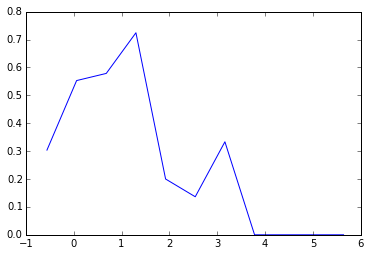

In [12]:
FamilySize_mean = train[['FamilySize', 'Survived']].groupby(['FamilySize'],as_index=False).mean()
plt.plot(FamilySize_mean['FamilySize'], FamilySize_mean['Survived'])

Pattern is not linear - add squared family size variable.

In [13]:
# Pattern is not linear - add squared family size variable
train['FamilySizeSq'] = train['FamilySize']*train['FamilySize']
test['FamilySizeSq'] = test['FamilySize']*test['FamilySize']

 ## Name Length

Name length may be correlated with income status, nobility, or origin, and therefore have an impact on survival.

In [14]:
train['NameLength'] = train['Name'].apply(lambda x: len(x))  
test['NameLength'] = test['Name'].apply(lambda x: len(x)) 

Let's see some descriptive statistics for name length.

In [15]:
train['NameLength'].describe()

count    891.000000
mean      26.965208
std        9.281607
min       12.000000
25%       20.000000
50%       25.000000
75%       30.000000
max       82.000000
Name: NameLength, dtype: float64

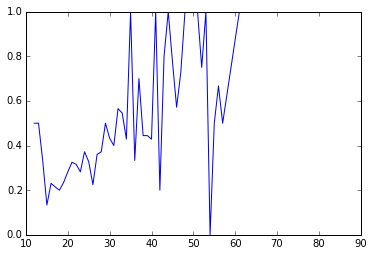

In [16]:
NameLength_mean = train[['NameLength', 'Survived']].groupby(['NameLength'],as_index=False).mean()
plt.plot(NameLength_mean['NameLength'], NameLength_mean['Survived'])

It seems that probability of survival is increasing with name size, though variance is increasing too (due to small number of observations, only 25% of observations fall above 30).

Normalize name length around it's mean and to a unit variance.

In [17]:
scalerNL = preprocessing.StandardScaler().fit(train['NameLength'])
train['NameLength'] = scalerNL.transform(train['NameLength']) 
test['NameLength'] = scalerNL.transform(test['NameLength']) 

C:\Users\Daria\AppData\Local\Dato\Dato Launcher\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Daria\AppData\Local\Dato\Dato Launcher\lib\site-packages\sklearn\preprocessing\data.py:583: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\Daria\AppData\Local\Dato\Dato Launcher\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Daria\AppData\Local\Dato\Dato Launcher\lib\site-packages\sklearn\preprocessing\data.py:646: DeprecationWarning: Passing 1

## Title

Extract title from a name. 

In [18]:
def get_title(name):
    # Titles always consist of capital and lowercase letters, and end with a period.
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

In [19]:
# Get all the titles
titles_train = train['Name'].apply(get_title)
titles_test = test['Name'].apply(get_title)

# print counts for each title in training set
pd.value_counts(titles_train)

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Major         2
Mlle          2
Countess      1
Ms            1
Lady          1
Jonkheer      1
Don           1
Mme           1
Capt          1
Sir           1
dtype: int64

Map each title to an integer.  Some titles are very rare, and are compressed into the same codes as other titles.

In [20]:
title_mapping = {"Mr": 1,
                 "Miss": 2, "Mlle": 2, "Mme": 2,
                 "Mrs": 3, "Ms": 3, "Dona": 3, "Lady": 3, "Countess": 3,
                 "Master": 4,
                 "Dr": 5,
                 "Rev": 6,
                 "Major": 7, "Col": 7, "Sir": 7, "Don": 7, "Jonkheer": 7, "Capt": 7,
                 }
for k,v in title_mapping.items():
    titles_train[titles_train == k] = v
    titles_test[titles_test == k] = v

# Add in the title column.
train['Title'] = titles_train
test['Title'] = titles_test

In [21]:
# Mean survival for each title
Title_mean = train[['Title', 'Survived']].groupby(['Title'],as_index=False).mean()
Title_mean.sort('Survived')

,Title,Survived
5,6,0.000000
0,1,0.156673
6,7,0.375000
4,5,0.428571
3,4,0.575000
1,2,0.702703
2,3,0.796875


It seems like all title categories had distinct mean survival. Grown up females on average survived more often, then young females and young males. None of The Reverends in the sample survived.

In [22]:
# create dummy variables for Title column & drop 1 (Mr)
Title_dummies_train  = pd.get_dummies(train['Title'], prefix = 'Title')
Title_dummies_train.drop(['Title_1'], axis=1, inplace=True)

Title_dummies_test  = pd.get_dummies(test['Title'], prefix = 'Title')
Title_dummies_test.drop(['Title_1'], axis=1, inplace=True)

train = train.join(Title_dummies_train)
test  = test.join(Title_dummies_test)

## Fare

Fare has one missing value in test set - replace with median fare.

In [23]:
test['Fare'] = test['Fare'].fillna(test['Fare'].median())

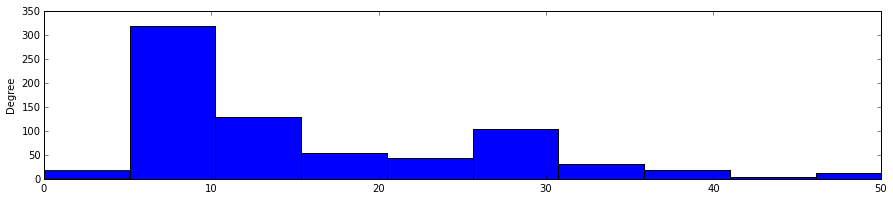

In [24]:
# plot
train['Fare'].plot(kind='hist', figsize=(15,3),bins=100, xlim=(0,50))

Fare is right skewed. Log transformartion will improve skew and kurtosis.

In [25]:
train['Fare'] = np.log(train['Fare']+1)
test['Fare'] = np.log(test['Fare']+1)

And normalize around zero with unit variance.

In [26]:
scalerF = preprocessing.StandardScaler().fit(train['Fare'])
train['Fare'] = scalerF.transform(train['Fare']) 
test['Fare'] = scalerF.transform(test['Fare']) 

C:\Users\Daria\AppData\Local\Dato\Dato Launcher\lib\site-packages\sklearn\preprocessing\data.py:583: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\Daria\AppData\Local\Dato\Dato Launcher\lib\site-packages\sklearn\preprocessing\data.py:646: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\Daria\AppData\Local\Dato\Dato Launcher\lib\site-packages\sklearn\preprocessing\data.py:646: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape 

## Pclass

Passenger Class: 1 = 1st, 2 = 2nd, 3 = 3rd. It is a proxy for socio-economic status (SES) 1st ~ Upper; 2nd ~ Middle; 3rd ~ Lower.

In [27]:
Pclass_mean = train[['Pclass', 'Survived']].groupby(['Pclass'],as_index=False).mean()
Pclass_mean.sort('Pclass')

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


Higher class passengers have higher survival rate, but the ralition is not linear, thus we need to convert Pclass into dummy variable.

In [28]:
# create dummy variables for Pclass column, & drop 3rd class as it has the lowest average of survived passengers
pclass_dummies_titanic  = pd.get_dummies(train['Pclass'], prefix = 'Class')
pclass_dummies_titanic.drop(['Class_3'], axis=1, inplace=True)

pclass_dummies_test  = pd.get_dummies(test['Pclass'], prefix = 'Class')
pclass_dummies_test.drop(['Class_3'], axis=1, inplace=True)

train.drop(['Pclass'],axis=1,inplace=True)
test.drop(['Pclass'],axis=1,inplace=True)

train = train.join(pclass_dummies_titanic)
test  = test.join(pclass_dummies_test)

## Age

In [29]:
train['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [30]:
test['Age'].describe()

count    332.000000
mean      30.272590
std       14.181209
min        0.170000
25%       21.000000
50%       27.000000
75%       39.000000
max       76.000000
Name: Age, dtype: float64

20% of Age data is missing for both training and test sets.

In [31]:
train['AgeNull'] = train['Age'].isnull()
test['AgeNull'] = test['Age'].isnull()

In [32]:
AgeNull_means = train[['AgeNull', 'Survived']].groupby(['AgeNull'],as_index=False).mean()
AgeNull_SibSp = train[['AgeNull', 'SibSp']].groupby(['AgeNull'],as_index=False).mean()
AgeNull_means['SibSp'] = AgeNull_SibSp['SibSp']
AgeNull_Parch = train[['AgeNull', 'Parch']].groupby(['AgeNull'],as_index=False).mean()
AgeNull_means['Parch'] = AgeNull_Parch['Parch']
AgeNull_Fare = train[['AgeNull', 'Fare']].groupby(['AgeNull'],as_index=False).mean()
AgeNull_means['Fare'] = AgeNull_Fare['Fare']
AgeNull_means

,AgeNull,Survived,SibSp,Parch,Fare
0,False,0.406162,0.512605,0.431373,0.082361
1,True,0.293785,0.564972,0.180791,-0.332235


Average survival rate, fare and number of parents/childred is different for individuals with missing age data. Therefore, I suspect that the data is not missing at random. 

Use both train and test data to model missing values in age.

In [33]:
train_wo = train.drop(['Survived'], axis=1)
all_data = pd.concat((train_wo, test), axis=0, ignore_index=True) # concatenate train and test data into one table

In [34]:
missing = all_data.index[all_data['Age'].isnull()]
non_missing = all_data.index[all_data['Age'].notnull()]

Use linear regression to predict missing values.

In [35]:
alg = LinearRegression()

predictors = ['Title_2','Title_3','Title_4','Title_5','Title_6','Title_7', 
              'SibSp', 'Parch', 'Fare', 'Class_1','Class_2', 'C', 'Q']

train_predictors = (all_data[predictors].iloc[non_missing,:])
# The target we're using to train the algorithm.
train_target = all_data['Age'].iloc[non_missing]
# Training the algorithm using the predictors and target.
alg.fit(train_predictors, train_target)
# We can now make predictions on the missing data
all_data['Age'].iloc[missing] =  alg.predict(all_data[predictors].iloc[missing,:])
# Truncate values of Age at zero to be non-negative
all_data.loc[all_data['Age']<0,'Age'] = 0

C:\Users\Daria\AppData\Local\Dato\Dato Launcher\lib\site-packages\pandas\core\indexing.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [36]:
all_data['Age'].describe()

count    1309.000000
mean       29.754081
std        13.454828
min         0.000000
25%        22.000000
50%        29.000000
75%        37.000000
max        80.000000
Name: Age, dtype: float64

Splitting back to train and test data.

In [37]:
df_train=all_data[0:891]
df_train = pd.concat((df_train, train[['Survived']]), axis=1) # add Survived column
df_test=all_data[891:]

I do not normalize age just yet, because I will use it next to define a child, and will normalize it after.

# Sex

As we saw from Title, children on aboard seem to have a high chances for Survival. So, we can classify passengers as males, females, and child.

In [38]:
def get_person(passenger):
    age,sex = passenger
    return 'child' if age < 16 else sex
    
df_train['Person'] = df_train[['Age','Sex']].apply(get_person,axis=1)
df_test['Person']  = df_test [['Age','Sex']].apply(get_person,axis=1)

# No need to use Sex column since we created Person column
df_train.drop(['Sex'],axis=1,inplace=True)
df_test.drop(['Sex'],axis=1,inplace=True)

C:\Users\Daria\AppData\Local\Dato\Dato Launcher\lib\site-packages\IPython\kernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Daria\AppData\Local\Dato\Dato Launcher\lib\site-packages\IPython\kernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [39]:
Pclass_mean = df_train[['Person', 'Survived']].groupby(['Person'],as_index=False).mean()
Pclass_mean.sort('Person')

,Person,Survived
0,child,0.547368
1,female,0.775665
2,male,0.161351


In [40]:
# create dummy variables for Person column, & drop Male
person_dummies_train  = pd.get_dummies(df_train['Person'])
person_dummies_train.drop(['male'], axis=1, inplace=True)

person_dummies_test  = pd.get_dummies(df_test['Person'])
person_dummies_test.drop(['male'], axis=1, inplace=True)

df_train = df_train.join(person_dummies_train)
df_test  = df_test.join(person_dummies_test)

df_train.drop(['Person'],axis=1,inplace=True)
df_test.drop(['Person'],axis=1,inplace=True)

Finally, normalize age around zero with unit variance.

In [41]:
scalerAge = preprocessing.StandardScaler().fit(df_train['Age'])
df_train['Age'] = scalerAge.transform(df_train['Age']) 
df_test['Age'] = scalerAge.transform(df_test['Age']) 

C:\Users\Daria\AppData\Local\Dato\Dato Launcher\lib\site-packages\sklearn\preprocessing\data.py:583: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\Daria\AppData\Local\Dato\Dato Launcher\lib\site-packages\sklearn\preprocessing\data.py:646: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\Daria\AppData\Local\Dato\Dato Launcher\lib\site-packages\sklearn\preprocessing\data.py:646: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape 

Drop all the useless colums.

In [42]:
df_train.drop(['Name','SibSp', 'Parch', 'Ticket', 'Cabin', 'Title', 'AgeNull'],axis=1,inplace=True)
df_test.drop(['Name','SibSp', 'Parch', 'Ticket', 'Cabin', 'Title', 'AgeNull'],axis=1,inplace=True)

In [43]:
df_train.head(10)

,PassengerId,Age,Fare,C,Q,FamilySize,FamilySizeSq,NameLength,Title_2,Title_3,Title_4,Title_5,Title_6,Title_7,Class_1,Class_2,Survived,child,female
0,1,-0.563914,-0.879741,0,0,0.059160,0.003500,-0.427451,0,0,0,0,0,0,0,0,0,0,0
1,2,0.615541,1.361220,1,0,0.059160,0.003500,2.590962,0,1,0,0,0,0,1,0,1,0,1
2,3,-0.269050,-0.798540,0,0,-0.560975,0.314693,-0.535252,1,0,0,0,0,0,0,0,1,0,1
3,4,0.394394,1.062038,0,0,0.059160,0.003500,1.836359,0,1,0,0,0,0,1,0,1,0,1
4,5,0.394394,-0.784179,0,0,-0.560975,0.314693,-0.319651,0,0,0,0,0,0,0,0,0,0,0
5,6,0.371059,-0.738616,0,1,-0.560975,0.314693,-1.182055,0,0,0,0,0,0,0,0,0,0,0
6,7,1.794997,1.038146,0,0,-0.560975,0.314693,-0.427451,0,0,0,0,0,0,1,0,0,0,0
7,8,-2.038234,0.136499,0,0,1.919564,3.684726,0.327152,0,0,1,0,0,0,0,0,0,1,0
8,9,-0.195334,-0.481456,0,0,0.679295,0.461441,2.375361,0,1,0,0,0,0,0,0,1,0,1
9,10,-1.153642,0.489438,1,0,0.059160,0.003500,0.866154,0,1,0,0,0,0,0,1,1,1,0


# Classification Algorithms

In [44]:
all_predictors = ['Age', 'Fare', 'C', 'Q', 'FamilySize', 'FamilySizeSq', 'NameLength', 'Class_1','Class_2', 'child', 'female', 
                 'Title_2','Title_3','Title_4','Title_5','Title_6','Title_7']
no_title_predictors = ['Age', 'Fare', 'C', 'Q', 'FamilySize', 'FamilySizeSq', 'NameLength', 'Class_1','Class_2', 'child', 
                       'female']

Separate data into training and testing data sets.

In [45]:
train_data, test_data = train_test_split(df_train, test_size=0.2, random_state=42)

## Simple Logistic Regression

In [46]:
logistic = LogisticRegression()
logistic.fit(train_data[all_predictors], train_data['Survived'])
print logistic.score(test_data[all_predictors], test_data["Survived"])

0.826815642458


In [47]:
logistic.coef_

array([[-0.23872263,  0.41594464,  0.36901852,  0.2340289 , -0.38793008,
        -0.19824214,  0.03418313,  1.10737438,  0.76611778,  1.37045838,
         1.6337104 ,  0.92067827,  1.70200435,  1.3129437 ,  0.18568668,
        -0.57103816,  0.33652938]])

In [48]:
logistic = LogisticRegression()
logistic.fit(train_data[no_title_predictors], train_data['Survived'])
print logistic.score(test_data[no_title_predictors], test_data["Survived"])
logistic.coef_

0.826815642458


array([[-0.21407536,  0.39556066,  0.39032684,  0.19624627, -0.24895857,
        -0.22406   ,  0.16239932,  1.06701097,  0.77354106,  2.17371838,
         2.67230882]])

## Ridge Classifier (L2 penalty)

Use k-fold cross validation to find the optimal L2 penalty for ridge regression.

In [49]:
ridge = RidgeClassifierCV(alphas = np.logspace(0, 1, num=1000))
ridge.fit(train_data[all_predictors], train_data['Survived'])

RidgeClassifierCV(alphas=array([  1.     ,   1.00231, ...,   9.97698,  10.     ]),
         class_weight=None, cv=None, fit_intercept=True, normalize=False,
         scoring=None)

In [50]:
ridge.alpha_

5.1726573872160193

In [51]:
ridge.score(test_data[all_predictors], test_data['Survived'])

0.82122905027932958

In [52]:
ridge.coef_

array([[-0.08350369,  0.11684021,  0.14159756,  0.08250713, -0.19644965,
        -0.00562247, -0.00510736,  0.39445519,  0.29111215,  0.48113421,
         0.61841584,  0.37301458,  0.66558689,  0.44013222,  0.08328526,
        -0.20636993,  0.12272852]])

It seems like L2 penaty does not improve performance of logistic regression.

## Naive Bayes classifier

I would not expct NB conditional independence assumption to holds in this problem (Title, Age, Female and Child are probably correlated), but still let's run the classifier and see how it performs. 

In [53]:
gaussian = GaussianNB()
gaussian.fit(train_data[all_predictors], train_data['Survived'])
gaussian.score(test_data[all_predictors], test_data['Survived'])

0.44692737430167595

Let's use all predictors but title and see how it performs.

In [54]:
gaussian = GaussianNB()
gaussian.fit(train_data[no_title_predictors], train_data['Survived'])
gaussian.score(test_data[no_title_predictors], test_data['Survived'])

0.78770949720670391

Now the performance is much better, but a simple logistic regression still outperforms it.

## K -  Nearest Neighbors

Now let's try non parametric classifier.

In [55]:
knn = KNeighborsClassifier()

And use grid search to tune up the parameters of KNN classifier.

In [56]:
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': 1,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [57]:
# Utility function to report best scores
def report(grid_scores, n_top=3):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")

In [177]:
# build a classifier
knn = KNeighborsClassifier()

# grid over parameters
param_grid = {"metric": ["minkowski", "manhattan", "chebyshev"], 
              "n_neighbors": list(range(1,41)),
              "weights": ["uniform", "distance"]}

# run grid search
grid_search = GridSearchCV(knn, param_grid=param_grid, cv = 178)
start = time()
grid_search.fit(train_data[all_predictors], train_data['Survived'])

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.grid_scores_)))
report(grid_search.grid_scores_)

GridSearchCV took 311.32 seconds for 240 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.829 (std: 0.189)
Parameters: {'n_neighbors': 16, 'metric': 'manhattan', 'weights': 'uniform'}

Model with rank: 2
Mean validation score: 0.827 (std: 0.182)
Parameters: {'n_neighbors': 18, 'metric': 'manhattan', 'weights': 'uniform'}

Model with rank: 3
Mean validation score: 0.826 (std: 0.192)
Parameters: {'n_neighbors': 17, 'metric': 'manhattan', 'weights': 'uniform'}



See what will be the score on test set for the knn classifier with tuned parameters.

In [181]:
knn = KNeighborsClassifier(n_neighbors = 16, metric = 'manhattan', weights = 'uniform')
knn.fit(train_data[all_predictors], train_data['Survived'])
knn.score(test_data[all_predictors], test_data['Survived'])

0.81005586592178769

##  Support Vector Machines

In [192]:
# build a classifier
svc = SVC()

# grid over parameters
param_grid = {"kernel": ["linear", "rbf", "sigmoid"],
              "gamma": [1e-3, 1e-4],
              "C": [1, 10, 100, 1000]}
                    
# run grid search
grid_search = GridSearchCV(svc, param_grid=param_grid, cv = 5)
start = time()
grid_search.fit(train_data[all_predictors], train_data['Survived'])

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.grid_scores_)))
report(grid_search.grid_scores_)

GridSearchCV took 440.50 seconds for 24 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.827 (std: 0.022)
Parameters: {'kernel': 'rbf', 'C': 1000, 'gamma': 0.001}

Model with rank: 2
Mean validation score: 0.823 (std: 0.024)
Parameters: {'kernel': 'linear', 'C': 10, 'gamma': 0.001}

Model with rank: 3
Mean validation score: 0.823 (std: 0.024)
Parameters: {'kernel': 'linear', 'C': 10, 'gamma': 0.0001}



In [193]:
svc = SVC(kernel = 'rbf', C = 1000, gamma = 0.001)
svc.fit(train_data[all_predictors], train_data['Survived'])
svc.score(test_data[all_predictors], test_data['Survived']) 

0.81564245810055869

## Decision Tree Classifier

It is possible that our features are not linear, moreover, there are a lot of categorical variables in the data. Therefore, Decision Trees may perform better on our data. 

In [195]:
# build a classifier
tree = DecisionTreeClassifier()

# grid over parameters
param_grid = {"max_depth": [3, None],
              "max_features": list(range(1,18)),
              "min_samples_split": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              "min_samples_leaf": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              "criterion": ["gini", "entropy"]}
                    
# run grid search
grid_search = GridSearchCV(tree, param_grid=param_grid, cv = 5)
start = time()
grid_search.fit(train_data[all_predictors], train_data['Survived'])

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.grid_scores_)))
report(grid_search.grid_scores_)

GridSearchCV took 217.97 seconds for 6800 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.824 (std: 0.018)
Parameters: {'max_features': 13, 'min_samples_split': 10, 'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 7}

Model with rank: 2
Mean validation score: 0.824 (std: 0.021)
Parameters: {'max_features': 15, 'min_samples_split': 4, 'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 6}

Model with rank: 3
Mean validation score: 0.824 (std: 0.021)
Parameters: {'max_features': 15, 'min_samples_split': 4, 'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 7}



In [197]:
tree = DecisionTreeClassifier(max_features = 13, min_samples_split = 10, criterion = 'entropy', max_depth = 3,
                              min_samples_leaf = 7)
tree.fit(train_data[all_predictors], train_data['Survived'])
tree.score(test_data[all_predictors], test_data['Survived']) 

0.74860335195530725

In [198]:
tree.feature_importances_

array([ 0.07851363,  0.00417512,  0.        ,  0.        ,  0.03865113,
        0.        ,  0.        ,  0.09888482,  0.05748556,  0.        ,
        0.        ,  0.21626396,  0.50602578,  0.        ,  0.        ,
        0.        ,  0.        ])

Features with non-zero importance: 'Age', 'Fare', 'FamilySize', 'Class_1','Class_2', 'Title_2' ("Miss", "Mlle", "Mme"), 
'Title_3' ("Mrs", "Ms", "Dona", "Lady", "Countess")

# Ensemble Classifiers

## Random Forest

In [207]:
# build a classifier
clf = RandomForestClassifier(n_estimators=100)

# use a full grid over all parameters
param_grid = {"max_depth": [3, None],
              "max_features": list(range(2,16)),
              "min_samples_split": list(range(2,10)),
              "min_samples_leaf": list(range(2,10)),
              "bootstrap": [False],
              "criterion": ["entropy"]}

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid)
start = time()
grid_search.fit(train_data[all_predictors], train_data['Survived'])

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.grid_scores_)))
report(grid_search.grid_scores_)

GridSearchCV took 2183.55 seconds for 1792 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.834 (std: 0.002)
Parameters: {'bootstrap': False, 'min_samples_leaf': 4, 'min_samples_split': 9, 'criterion': 'entropy', 'max_features': 2, 'max_depth': None}

Model with rank: 2
Mean validation score: 0.834 (std: 0.014)
Parameters: {'bootstrap': False, 'min_samples_leaf': 7, 'min_samples_split': 5, 'criterion': 'entropy', 'max_features': 9, 'max_depth': None}

Model with rank: 3
Mean validation score: 0.834 (std: 0.006)
Parameters: {'bootstrap': False, 'min_samples_leaf': 7, 'min_samples_split': 6, 'criterion': 'entropy', 'max_features': 11, 'max_depth': None}



In [208]:
random_forest = RandomForestClassifier(random_state=1, n_estimators=100, bootstrap = False, min_samples_leaf = 4,
                                       min_samples_split = 9, max_features = 2, max_depth = None, criterion = 'entropy')
random_forest.fit(train_data[all_predictors], train_data['Survived'])
random_forest.score(test_data[all_predictors], test_data['Survived'])

0.84357541899441346

In [209]:
random_forest.feature_importances_

array([  1.02405099e-01,   1.54832518e-01,   1.80067603e-02,
         7.01339593e-03,   5.40422219e-02,   4.40290527e-02,
         1.15805081e-01,   4.41134861e-02,   3.34694703e-02,
         1.67755287e-02,   2.12011208e-01,   9.03998503e-02,
         9.52767297e-02,   8.97989475e-03,   1.87712747e-04,
         2.50565916e-03,   1.46330924e-04])

## Gradient Boosting

In [213]:
GB = GradientBoostingClassifier(n_estimators=100)

param_grid = {"loss" : ["deviance", "exponential"],
             "learning_rate": [0.1],
             "max_depth": [3, None],
             "min_samples_split": [3, 5, 8, 11, 14, 20],
             "min_samples_leaf": [8, 11, 14, 17, 20],
             "max_features": [2, 5, 8, 11, 14]}

# run grid search
grid_search = GridSearchCV(GB, param_grid=param_grid)
start = time()
grid_search.fit(train_data[all_predictors], train_data['Survived'])

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.grid_scores_)))
report(grid_search.grid_scores_)

GridSearchCV took 325.07 seconds for 384 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.836 (std: 0.018)
Parameters: {'loss': 'exponential', 'learning_rate': 0.1, 'min_samples_leaf': 14, 'min_samples_split': 11, 'max_features': 2, 'max_depth': None}

Model with rank: 2
Mean validation score: 0.834 (std: 0.010)
Parameters: {'loss': 'exponential', 'learning_rate': 0.1, 'min_samples_leaf': 14, 'min_samples_split': 5, 'max_features': 2, 'max_depth': None}

Model with rank: 3
Mean validation score: 0.833 (std: 0.012)
Parameters: {'loss': 'deviance', 'learning_rate': 0.1, 'min_samples_leaf': 14, 'min_samples_split': 20, 'max_features': 8, 'max_depth': 3}



In [235]:
GB = GradientBoostingClassifier(n_estimators=100, loss = 'exponential', learning_rate = 0.1,
                                min_samples_leaf = 14, min_samples_split = 11, max_features = 2, max_depth = None)
GB.fit(train_data[all_predictors], train_data['Survived'])
GB.score(test_data[all_predictors], test_data['Survived']) # Mean validation score: 0.843 (std: 0.016) # 0.75598

0.84357541899441346

## Ada Boost Classifier

In [214]:
Ada = AdaBoostClassifier(n_estimators=100, algorithm='SAMME')

#param_grid = {"base_estimator" : [DecisionTreeClassifier(), RidgeClassifierCV()],
#             "learning_rate": [0.01, 0.5, 0.1]}

param_grid = {"base_estimator" : [DecisionTreeClassifier(max_features = 13, min_samples_split = 10, criterion = 'entropy', 
                                                         max_depth = 3, min_samples_leaf = 7)], 
              "learning_rate": np.logspace(-5, 0, num=20)}
             
# run grid search
grid_search = GridSearchCV(Ada, param_grid=param_grid)
start = time()
grid_search.fit(train_data[all_predictors], train_data['Survived'])

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.grid_scores_)))
report(grid_search.grid_scores_)

GridSearchCV took 31.55 seconds for 20 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.817 (std: 0.007)
Parameters: {'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=13, max_leaf_nodes=None, min_samples_leaf=7,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'), 'learning_rate': 0.54555947811685146}

Model with rank: 2
Mean validation score: 0.815 (std: 0.006)
Parameters: {'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=13, max_leaf_nodes=None, min_samples_leaf=7,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'), 'learning_rate': 0.16237767391887209}

Model with rank: 3
Mean validation score: 0.815 (std: 0.010)
Parameters: {'base_estimator': DecisionTreeClassifier(class_

In [ ]:
Ada = AdaBoostClassifier(n_estimators=100, algorithm='SAMME', 
                         base_estimator = DecisionTreeClassifier(max_features = 13, min_samples_split = 10, criterion = 'entropy', 
                                                         max_depth = 3, min_samples_leaf = 7), learning_rate = 0.54555947811685146)
Ada.fit(train_data[all_predictors], train_data['Survived'])
Ada.score(test_data[all_predictors], test_data['Survived'])

In [217]:
Ada = AdaBoostClassifier(n_estimators=100, algorithm='SAMME')

#param_grid = {"base_estimator" : [DecisionTreeClassifier(), RidgeClassifierCV()],
#             "learning_rate": [0.01, 0.5, 0.1]}

param_grid = {"base_estimator" : [RidgeClassifierCV()], 
              "learning_rate": np.logspace(-5, 0, num=20)}
             
# run grid search
grid_search = GridSearchCV(Ada, param_grid=param_grid)
start = time()
grid_search.fit(train_data[all_predictors], train_data['Survived'])

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.grid_scores_)))
report(grid_search.grid_scores_)

GridSearchCV took 531.54 seconds for 20 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.829 (std: 0.010)
Parameters: {'base_estimator': RidgeClassifierCV(alphas=(0.1, 1.0, 10.0), class_weight=None, cv=None,
         fit_intercept=True, normalize=False, scoring=None), 'learning_rate': 1.0000000000000001e-05}

Model with rank: 2
Mean validation score: 0.829 (std: 0.010)
Parameters: {'base_estimator': RidgeClassifierCV(alphas=(0.1, 1.0, 10.0), class_weight=None, cv=None,
         fit_intercept=True, normalize=False, scoring=None), 'learning_rate': 1.8329807108324375e-05}

Model with rank: 3
Mean validation score: 0.829 (std: 0.010)
Parameters: {'base_estimator': RidgeClassifierCV(alphas=(0.1, 1.0, 10.0), class_weight=None, cv=None,
         fit_intercept=True, normalize=False, scoring=None), 'learning_rate': 3.3598182862837813e-05}



In [218]:
Ada = AdaBoostClassifier(n_estimators=100, algorithm='SAMME', 
                         base_estimator = RidgeClassifierCV(), learning_rate = 1.0000000000000001e-05)
Ada.fit(train_data[all_predictors], train_data['Survived'])
Ada.score(test_data[all_predictors], test_data['Survived'])

0.81005586592178769

## Bagging

Reduces variance of base estimator.

In [232]:
Bagging = BaggingClassifier(n_estimators=100)


param_grid = {"base_estimator" : [DecisionTreeClassifier(), 
                                  RidgeClassifierCV(), 
                                  SVC(kernel = 'rbf', C = 1000, gamma = 0.001),
                                  KNeighborsClassifier(n_neighbors = 16, metric = 'manhattan', weights = 'uniform')],
             "max_features": list(range(2,15))}

# run grid search
grid_search = GridSearchCV(Bagging, param_grid=param_grid)
start = time()
grid_search.fit(train_data[all_predictors], train_data['Survived'])

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.grid_scores_)))
report(grid_search.grid_scores_)

GridSearchCV took 368.37 seconds for 52 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.827 (std: 0.022)
Parameters: {'max_features': 8, 'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')}

Model with rank: 2
Mean validation score: 0.827 (std: 0.012)
Parameters: {'max_features': 8, 'base_estimator': SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)}

Model with rank: 3
Mean validation score: 0.826 (std: 0.014)
Parameters: {'max_features': 10, 'base_estimator': SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degr

In [233]:
Bagging = BaggingClassifier(n_estimators=100, base_estimator = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'), max_features = 8)
Bagging.fit(train_data[all_predictors], train_data['Survived'])
Bagging.score(test_data[all_predictors], test_data['Survived'])

0.84357541899441346

## VotingClassifier

Choose the best classifiers from above and tune up weighs. Searching over all possible weights is very time consuming, therefore, let's just search for weights in range 1 to 3. 

In [73]:
clf1 = LogisticRegression()
clf2 = SVC(kernel = 'rbf', C = 1000, gamma = 0.001, probability=True)
clf3 = KNeighborsClassifier(n_neighbors = 5)
clf4 = RandomForestClassifier(random_state=0, n_estimators=300, bootstrap = False, min_samples_leaf = 7,
                                       min_samples_split = 7, max_features = 10, max_depth = None, criterion = 'gini')
clf5 = GradientBoostingClassifier(random_state=1, n_estimators=100, loss = 'exponential', learning_rate = 0.1,
                                min_samples_leaf = 20, min_samples_split = 3, max_features = 6, max_depth = 16)
#clf6 = AdaBoostClassifier(n_estimators=100, algorithm='SAMME', base_estimator = RidgeClassifierCV(), learning_rate = 0.5)
clf7 = BaggingClassifier(n_estimators=100, base_estimator = KNeighborsClassifier(n_neighbors = 5), max_features = 6)

df = pd.DataFrame(columns=['w1', 'w2', 'w3', 'w4', 'w5', 'w7', 'mean', 'std'])

i = 0
for w1 in range(1,4):
    for w2 in range(1,4):
        for w3 in range(1,4):
            for w4 in range(1,4):
                for w5 in range(1,4):
                    for w7 in range(1,4):
                        if len(set((w1,w2,w3,w4,w5,w7))) == 1: # skip if all weights are equal
                            continue
                        eclf = VotingClassifier(estimators=[('lr', clf1), ('svc', clf2), ('knn', clf3), ('rf', clf4), 
                                                            ('gb', clf5), ('bagg', clf7)], 
                                                voting='soft', weights=[w1,w2,w3,w4,w5,w7])
                        scores = cross_val_score(estimator=eclf, 
                                                 X=train_data[all_predictors],
                                                 y=train_data['Survived'],
                                                 cv=5,
                                                 scoring='accuracy',
                                                  n_jobs=1)

                        df.loc[i] = [w1, w2, w3, w4, w5, w7, scores.mean(), scores.std()]
                        i += 1

df.sort(['mean', 'std'], ascending=[0, 0])

,w1,w2,w3,w4,w5,w7,mean,std
654,3,3,1,1,3,3,0.841335,0.022678
668,3,3,1,3,2,2,0.841315,0.022767
165,1,3,1,1,2,2,0.841315,0.022334
417,2,3,1,2,2,3,0.841315,0.022334
175,1,3,1,2,2,3,0.841295,0.020139
199,1,3,2,2,1,3,0.839936,0.022983
367,2,2,2,3,1,1,0.839936,0.022983
369,2,2,2,3,1,3,0.839936,0.022983
109,1,2,2,1,1,3,0.839936,0.021213
416,2,3,1,2,2,2,0.839917,0.023490


In [100]:
voting = VotingClassifier(estimators=[('lr', clf1), ('svc', clf2), ('knn', clf3), ('rf', clf4), ('gb', clf5), 
                                       ('bagg', clf7)], 
                                                voting='hard', weights =[3, 3, 1, 1, 3, 3])
voting.fit(train_data[all_predictors], train_data['Survived'])
voting.score(test_data[all_predictors], test_data['Survived'])

0.83798882681564246

Things that have not been considered here and can potentially improve scores:
1) Family size by definition only includes close family, and does not conside aunts, uncles, cousins, grandparents, unmarried couples etc. Extended family size can be recomputed using cabin number.
2) Cabin variable was ingnored, because it has a lot of missing values. However, it can be decomposed into deck and cabin number (letter and number) and missing values can be estimated from fare and class. This can be of potential importance, because location of the cabin on board may have high impact on survival.
3) Ticket variable was also omitted, becuase I do not see why ticket number would influence survival chances.
4) Other essemble classifiers could be consider to improve performance (i.e. Stacking)